### 이미지, 라벨 경로에서 파일 목록 리스트에 저장

In [ ]:
import os
 
img_root_dir = '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data'
label_root_dir = '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_labeling'
img_path_list = []
label_path_list = []

possible_img_extension = ['.png'] # 이미지 확장자
possible_label_extension = ['.json'] # 라벨 확장자
 
for (root, dirs, files) in os.walk(img_root_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_img_extension:
                img_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                img_path = img_path.replace('\\', '/') # \는 \\로 나타내야함         
                img_path_list.append(img_path)
                img_path_list.sort()

for (root, dirs, files) in os.walk(label_root_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_label_extension:
                label_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                label_path = label_path.replace('\\', '/') # \는 \\로 나타내야함         
                label_path_list.append(label_path)
                label_path_list.sort()
                             
print(img_path_list)
print(label_path_list)

['/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00001_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00003_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00006_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00007_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00009_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00011_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00012_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00016_PS3_K3A_NIA0276.png', '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00017_PS3_K3A_NIA0276.png', 

In [ ]:
# 파일 개수 확인
print(len(img_path_list))
print(len(label_path_list))

1144
1144


In [ ]:
def get_polygon_xy(ann_seg):
    polygon_x = [x for index, x in enumerate(ann_seg) if index % 2 == 0]
    polygon_y = [x for index, x in enumerate(ann_seg) if index % 2 == 1]
    polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
    polygon_xy = np.array(polygon_xy, np.int32)
    
    return polygon_xy

In [ ]:
def apply_mask(image, mask):
    image[:, :] = np.where(mask == 1, image[:, :] + 1, image[:, :])
    
    return image

In [ ]:
def get_mask(image_array_shape, polygon_xy):
    ## polygon 정보를 mask 정보로 변환. 
    zero_mask = np.zeros(image_array_shape) # mask 정보는 2차원 선호
    masked_polygon = cv2.fillPoly(zero_mask, [polygon_xy], 1)

    return masked_polygon

In [ ]:
# ann_seg_list에 있는 object들의 segmentation에 따라 instance segmentation 시각화. 
def draw_segment2(image_array, ann_seg_list, color_list, alpha):
    draw_image = image_array.copy()
    mask_array_shape = draw_image.shape[0:2]
    zero_mask = np.zeros(mask_array_shape)
    masked_image = zero_mask    # 지역변수 초기화

    # list형태로 입력된 segmentation 정보들을 각각 시각화
    for index, ann_seg in enumerate(ann_seg_list):
        # polygon 좌표로 변환. 
        polygon_xy = get_polygon_xy(ann_seg)

        # mask 정보 변환
        masked_polygon = get_mask(mask_array_shape, polygon_xy)
        
        # masking 적용. 
        masked_image = apply_mask(zero_mask, masked_polygon)

    return masked_image

In [ ]:
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np

green_color = (0, 255, 0)
color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]

for i, j in zip(img_path_list, label_path_list):

    # 원본 이미지 시각화 
    image_array = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    with open(j) as json_file:
        data_infos = json.load(json_file)

    ann_seg_list = [] # 빈 리스트 생성
    for k in range(len(data_infos['features'])):  # 이미지 내 폴리곤 개수만큼 반복
        imcoords = []
        if data_infos['features'][k]['properties']['road_imcoords'] == "":
            continue
        imcoords = list(map(float, data_infos['features'][k]['properties']['road_imcoords'].split(',')))

        ann_seg_list.append(imcoords)
    
    masked_image = draw_segment2(image_array, ann_seg_list, color_list, alpha=0.6)
    masked_image[masked_image > 1] = 1
    masked_image.astype(int)
    np.savetxt(i.replace('.png', '.txt'), masked_image, fmt = '%d', delimiter = ' ')
    print(i)

/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00001_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00003_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00006_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00007_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00009_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00011_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00012_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00016_PS3_K3A_NIA0276.png
/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_data/BLD00017_PS3_K3A_NIA0276.png
/content/drive/MyDrive/Share

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/AIFFEL/AIFFELTHON/Training/train_roads_data
# !rm -rf *.txt

In [ ]:
%cd /content/drive/MyDrive/SharedData/sia-satellite-data/Training

/content/drive/.shortcut-targets-by-id/1uNxfU21u6IAy0s4_NhW4JiaB2Hwbyv4k/SharedData/sia-satellite-data/Training


In [ ]:
!mkdir train_roads_annotation

In [ ]:
!ls

building_splits			  train_buildings_labeling
building_train_coco.json	  train_mix_annotation
building_val_coco.json		  train_mix_data
level2_train_building_annotation  train_road_annotation
level2_train_building_data	  train_roads_annotation
road_splits			  train_roads_data
train_building_annotation	  train_roads_labeling
train_buildings_data


In [ ]:
%cd train_roads_data

/content/drive/.shortcut-targets-by-id/1uNxfU21u6IAy0s4_NhW4JiaB2Hwbyv4k/SharedData/sia-satellite-data/Training/train_roads_data


In [ ]:
#cp *.png ../train

In [ ]:
cp *.txt ../train_roads_annotation

In [ ]:
import os

label_root_dir = '/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_annotation'
label_path_list = []

possible_label_extension = ['.txt'] # 라벨 확장자


for (root, dirs, files) in os.walk(label_root_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_label_extension:
                label_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                label_path = label_path.replace('\\', '/') # \는 \\로 나타내야함         
                label_path_list.append(label_path)
                label_path_list.sort()
                             
# 파일 개수 확인
print(len(label_path_list))

1144


# MMCV Install and import

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.11.0+cu113 True


In [ ]:
# Install MMCV
# 런타임 -> 런타임 "다시 시작" 후 아래 수행. 
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.3 MB 48 kB/s 
     |████████████████████████████████| 190 kB 8.6 MB/s 


# txt to png using mmcv, PIL, numpy ...

# 0 -> background : [0, 0, 0]
# 1 -> road : [255, 0, 255]
# 2 -> building : [0, 0, 255]

In [ ]:
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image
import cv2

# convert dataset annotation to semantic segmentation map
data_root = '/content/drive/MyDrive/SharedData/sia-satellite-data/Training'
#img_dir = 'train'
ann_dir = 'train_roads_annotation'

# define class and plaette for better visualization
classes = ('background', 'road')
palette = [[0, 0, 0], [255, 0, 255]]


In [ ]:
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.txt'):
    seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.txt', '.png')))

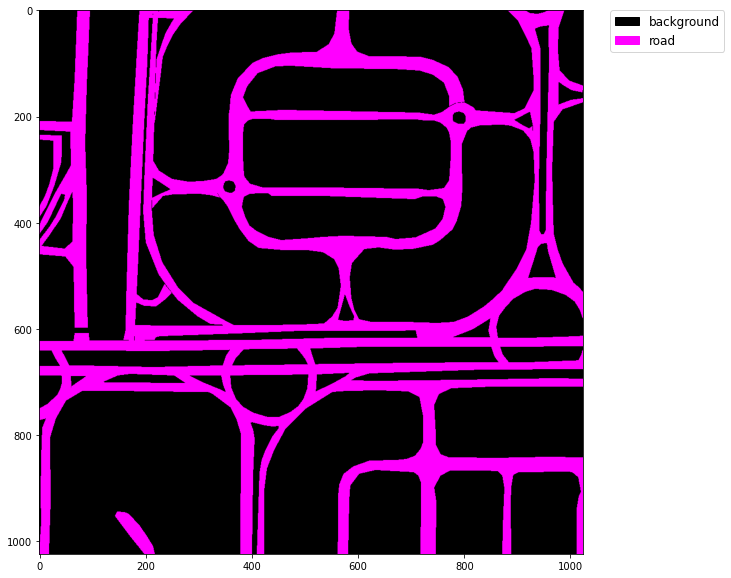

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches

img = Image.open('/content/drive/MyDrive/SharedData/sia-satellite-data/Training/train_roads_annotation/BLD00007_PS3_K3A_NIA0276.png')
plt.figure(figsize=(10, 10))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(2)]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()